# Introduction


#### Business problem:
Pitney Bowes FDR (Fullilment, Delivery & Returns) line of business allows retailers to easily deliver parcels to customers and  facilitate the return of merchandise If Customers are unsatisfied with products they can simply drop off the return parcels at any USPS (United States Post Office) Office, and the package will get transported to the closest Pitney Bowes FDR hub to be inducted into the Pitney Bowes carrier network. 
Once inducted into our network, the parcel gets transported from hub to hub (the Pitney Bowes FDR network) to the merchant’s warehouse.  One sss
One major requirement of these merchant’s is for Pitney Bowes to provide a forecast of the expected number of parcels that will be delivered at their warehouses. This helps predict the number of resources required to unload parcels as well as where and how to store it. 
The challenge with providing this information is that The resulting volume of parcels delivered to the  merchant’s warehouse can vary widely and is driven by external factors like seasonal sales and holidays. In addition, most warehouses have specific labor schedules which limit how much volume can be processed per day. 
In this data challenge, you will be given 3 months of historic da ta for pa ckages that ha ve been delivered to a single  merchant warehouse. 
<b>The aim is to use this historic data to predict the parcel volumes to arrive at the client's facility over the next 5 days (i.e., 5 numbers for Monday through Friday).</b>

#### Data:

The data is aggregated by delivery and induction date. The delivery column shows the total number of parcels that have been delivered to the merchant on any given day. The induction columns give you the induction volume per day across our PB FDR facilities. The time it takes a parcel to travel from the induction facility to the  merchant facility depends largely on the distance between these facilities. However, other factors like traffic, construction, and weather can effect the ablity for parcels to move from facility to facility.  In addition, the delivery methods chosen can very (expedited, normal, snail mail, etc…) Often PB is not aware of the specific service selected, only the expected date of arrival at the merchant’s warehouse. We have not provided that data here – but you are free to make assumptions if you feel it would be helpful to your model.


#### Output Format:
TBD, but all we need are your <b>5 parcel-volume predictions for June, 3rd - June, 7th 2019</b>. To evaluate your preditcions, we use the Mean Absolute Percentage Error.

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [2]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import scipy.stats as scs

from itertools import product                    # some useful functions

%matplotlib inline

In [3]:
#Reading the provided csv file into a pandas Dataframe
Delivery = pd.read_csv('~/work/shared/Delivery_Volume.csv', index_col=['DELIVERY_DATE'], parse_dates=['DELIVERY_DATE'])
Delivery.sort_index(inplace=True)
Delivery=Delivery.fillna(0)

In [4]:
#Data Sample
Delivery.head()

,DELIVERED_VOLUME,Facility_A,Facility_B,Facility_C,Facility_D,Facility_E,Facility_F,Facility_G,Facility_H,Facility_I,Facility_J,Facility_K
DELIVERY_DATE,,,,,,,,,,,,
2019-03-13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-14,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-15,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-18,0.0,0.0,0.0,0.0,55.0,3.0,0.0,45.0,86.0,0.0,16.0,0.0
2019-03-19,0.0,13.0,0.0,0.0,3.0,9.0,80.0,243.0,80.0,0.0,6.0,0.0


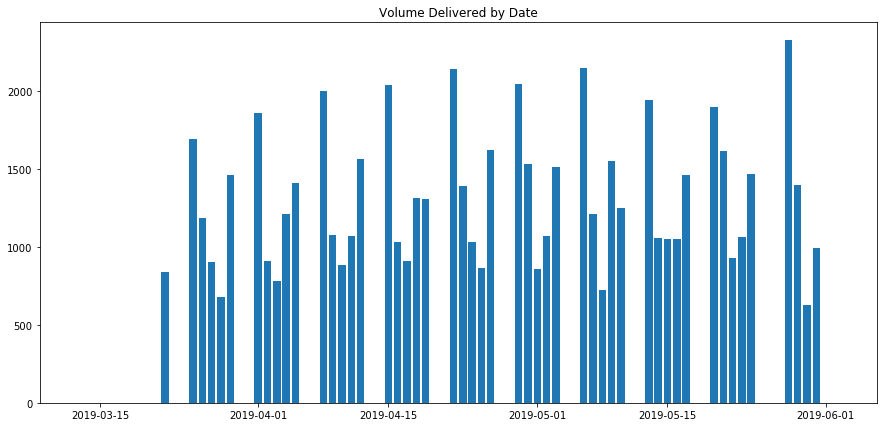

In [43]:
plt.figure(figsize=(15, 7))
#Delivery.plot.bar(figsize=(10,5))
plt.bar(Delivery.index,Delivery.DELIVERED_VOLUME)
plt.title('Volume Delivered by Date')
plt.grid(False)
plt.show()

The plot above shows the delivery volumes at the merchant facility per day. The merchant’s facility is closed on the Saturday and Sundays. Therefore, you  won’t see any recorded deliveries on the weekends. There were no deliveries on Memorial Day either. Looking at the data, you should identify a strong seasonal pattern the volume of parcels fluctuates quite a bit by weekday. This is why the clients are dependent on volume forecasts (on a daily basis) so they can manage their warehouse accordingly.

# Example
## Moving Averages

Using various Data Science methods provides you several ways to approach providing a forecast of the resulting volumes. Below we have included one simple approach. We will estimate the next days' volume by using the last days' volume. Given the daily fluctuation of volume, it is obvious that this is not a very promising approach. Another simple way illustrated would be to look at moving averages to smoothen out the predictions. Again, perhaps a little better but much better estimates can be determined using better more innovative approaches. Your job in this exercise is not only to code, but to think creatively how to structure a better estimate. 

In [44]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [93]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False,day_out=5):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    
    Delivery['SMA_{}'.format(day_out)]=0
    for i in range(0,Delivery.shape[0]-day_out,day_out):
        for j in range(day_out):
            sum_val=0
            for k in range(window):
                sum_val+= Delivery.iloc[i+k,0]
            Delivery.loc[Delivery.index[i+j],'SMA_{}'.format(day_out)] = np.round((sum_val/window),1)
    rolling_mean=Delivery['SMA_{}'.format(day_out)]

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:].iloc[:,0], rolling_mean[window:])
        deviation = np.std(series[window:].iloc[:,0] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:].iloc[:,0], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

#### Parameters:
- window - no of days to consider when calculating the average
- day_out - the number of days for which you are generating the forecasts

This is what you get when you calculate the average using the volumes delivered over the last 2 days

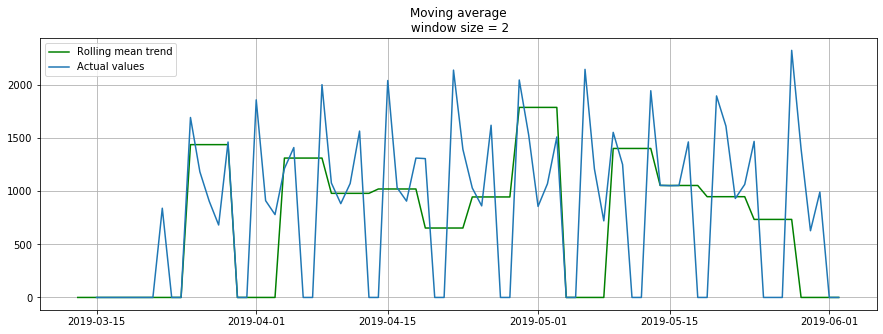

In [94]:
plotMovingAverage(Delivery,2,day_out=5)

As you can see, the forecast is a bit more smooth, but it misses the peaks in delivery volume. Now let's try doing so using the volumes over the previous 7 days.

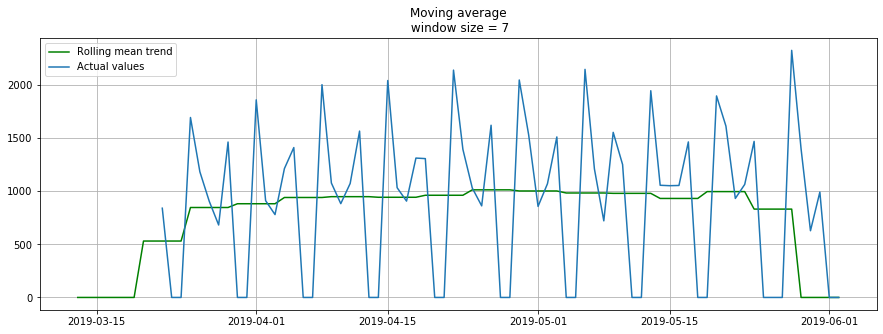

In [95]:
plotMovingAverage(Delivery, 7,day_out=5)

As expected, the predictions smoothen out more, but the also become less usefull since they eventually converge to the average daily delivery volume. Our clients need more accurate fore­ casts for the individual days.

### Notes and some ideas:
- You are not limited to the 13 columns (date, delivery total, induction totals for 11 facilities) provided in the data set, you can generate additional features that might be useful for your predictions. For instance, you could add a feature like weekday to your model. This might be helpful to capture weekday-specific patterns.

- Lag variables are very usefull for forecast problems. For instance, you could create addi­ tional columns like yesterdays volume (day-1), the day before yesterday (day-2), etc. This might be helpful when trying to use the induction volumes for your model, as they delivery volume follow the induction volumes (with a few days lag depending on where the induc­ tion happened) 

- You might consider using an ensemble approach – dividing the problem into different methods and using a voting system to determine the final estimate.  

- You could divide the volume into a fixed amount and a variable amount and optimize your analysis of the variable amount.

- When building your model, make sure that you get a good understanding of the model's performance by using the historic data for back-testing. Common methods for forecasting problems are rolling window approaches.

- The examples above are very basic examples for illustration. You could for instance explore time-series packages that are readily availabe, or try to build a ML model that makes use of additional features you generate. 


### Reach out if you have questions:
<span>Zoom</span>

### Further reading:
- [Time Series](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook)
- [Jupyter Notebooks](https://www.dataquest.io/blog/jupyter-notebook-tutorial/)

## Good luck!